This network (tries to) estimate the alignment level of 7.5 seconds ago. 

# Getting data and imports



In [2]:
import numpy as np      	                    
import pandas as pd
import os
from tensorflow import keras
from ncps import wirings
from ncps.tf import LTC
import matplotlib.pyplot as plt
import seaborn as sns

import utils 
import model_bold

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler 


# works with fMRI data 

We do not need any further delay, since we already use the HDF...


In [3]:
# NEW: Divide each run into training and testing sets; where ALIGNMENT LEVELS are the y values. 
# also included the MODEL into it!! 


def get_training_and_testing_sets(participant_id, run_id, plot=False): 

    df, voxel_list = utils.get_measurement_df(participant_id, run_id)
    column_arrays = []
    df = df.drop(df.index[-1]) #important! Otherwise the code does not work ("NaN" in array trips up mse...)
    df = df.drop(df.index[0])

    # THUS: SHIFT BY 5!! >> EQUALS 7.5 seconds. 

    y_conv, alignment_ts = model_bold.determine_true_time_series_from_events(participant_id,run_id, time_between_measurements = 1.5)
    alignment_ts = np.pad(alignment_ts, (5, 0), 'constant')

    plt.plot(alignment_ts)
    # I am filling the df alignment_level and model columns with zeros in the end, since I assume, that the event-table ended with the last event - even if it was earlier that the true experiment. 
    df.loc[:,"alignment_level"] = pd.Series(alignment_ts) 
    df["alignment_level"] = MinMaxScaler().fit_transform(np.array(df["alignment_level"]).reshape(-1,1)) 
    # df["model"] = y_conv[delay:-39+delay]
    df.loc[:,"model"] = pd.Series(y_conv) #[:-39])
    df = df.fillna(0)


    # Iterate over the voxel columns and append their values to the list
    voxel_list.append("model")

    for voxel in voxel_list:
        df[voxel] = MinMaxScaler().fit_transform(np.array(df[voxel]).reshape(-1,1)) 
        column_array = df[voxel].values
        column_arrays.append(column_array)


    # Combine the arrays into a single array with the desired shape
    data_x = np.column_stack(column_arrays)

    N = len(data_x[0])
    M = len(data_x)

    data_y = df['alignment_level'].values.reshape([M, 1, 1]).astype(np.float32)
    data_x = np.reshape(data_x, (M, 1, N))
    
    train_size = int(M * 0.8)
    test_size = int(M * 0.1)
    validation_size = M - train_size - test_size    # not used, just in case of interest 

    train_X, test_X, val_X = data_x[0:train_size,:,:], data_x[train_size:train_size+test_size,:,:], data_x[train_size+test_size:,:,:]
    train_y, test_y, val_y = data_y[0:train_size,:,:], data_y[train_size:train_size+test_size,:,:], data_y[train_size+test_size:,:,:]
    if plot: 
        plt.figure()
        plt.plot(train_y[:,0,0])
        plt.figure()
        plt.plot(test_y[:,0,0])    
        plt.figure()
        plt.plot(val_y[:,0,0])
    return train_X, test_X, val_X, train_y, test_y, val_y,N



## ATTENTION! I SWITCHED HERE VAL AND TEST - this is why I recommend calling the function as follows: 
# train_X, val_X, test_X, train_y, val_y, test_y, N = get_training_and_testing_sets(5,4)
    

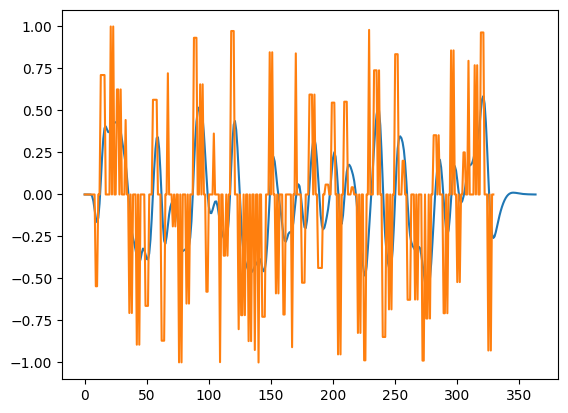

In [4]:
participant_id, run_id = 5,4 
plot=False 

df, voxel_list = utils.get_measurement_df(participant_id, run_id)
column_arrays = []
df = df.drop(df.index[-1]) #important! Otherwise the code does not work ("NaN" in array trips up mse...)
df = df.drop(df.index[0])
# df = df.drop(df.index[0])


# THUS: SHIFT BY 5!! >> EQUALS 7.5 seconds. 

y_conv, alignment_ts = model_bold.determine_true_time_series_from_events(participant_id,run_id, time_between_measurements = 1.5)
alignment_ts = np.pad(alignment_ts, (5, 0), 'constant')

plt.plot(alignment_ts)
# I am filling the df alignment_level and model columns with zeros in the end, since I assume, that the event-table ended with the last event - even if it was earlier that the true experiment. 
df.loc[:,"alignment_level"] = pd.Series(alignment_ts) 
df["alignment_level"] = MinMaxScaler().fit_transform(np.array(df["alignment_level"]).reshape(-1,1)) 
# df["model"] = y_conv[delay:-39+delay]
df.loc[:,"model"] = pd.Series(y_conv) #[:-39])
df = df.fillna(0)

# Iterate over the voxel columns and append their values to the list
voxel_list.append("model")

for voxel in voxel_list:
    df[voxel] = MinMaxScaler().fit_transform(np.array(df[voxel]).reshape(-1,1)) 
    column_array = df[voxel].values
    column_arrays.append(column_array)

# Combine the arrays into a single array with the desired shape
data_x = np.column_stack(column_arrays)

N = len(data_x[0])
M = len(data_x)

data_y = df['alignment_level'].values.reshape([M, 1, 1]).astype(np.float32)
data_x = np.reshape(data_x, (M, 1, N))

train_size = int(M * 0.8)
test_size = int(M * 0.1)
validation_size = M - train_size - test_size

train_X, test_X, val_X = data_x[0:train_size,:,:], data_x[train_size:train_size+test_size,:,:], data_x[train_size+test_size:,:,:]
train_y, test_y, val_y = data_y[0:train_size,:,:], data_y[train_size:train_size+test_size,:,:], data_y[train_size+test_size:,:,:]
if plot: 
    plt.figure()
    plt.plot(train_y[:,0,0])
    plt.figure()
    plt.plot(test_y[:,0,0])    
    plt.figure()
    plt.plot(val_y[:,0,0])
# train_X, test_X, val_X, train_y, test_y, val_y,N

In [5]:
alignment_ts.shape

(330,)

In [6]:
y_conv.shape

(364,)

In [7]:
df_wild = pd.DataFrame()

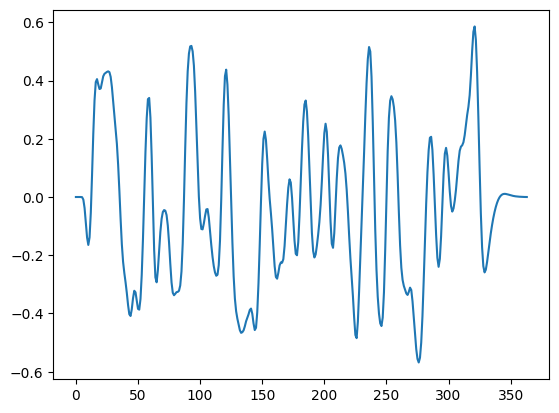

In [8]:
df_wild["alignment"] = alignment_ts
df_wild.loc[:,"model"] = pd.Series(y_conv) #[:-39])
df_wild
plt.plot(y_conv)

In [9]:
df

,voxel_1,voxel_2,voxel_3,voxel_4,voxel_5,voxel_6,voxel_7,voxel_8,voxel_9,voxel_10,...,voxel_95,voxel_96,voxel_97,voxel_98,voxel_99,voxel_100,voxel_mean,shifted_mean,alignment_level,model
1,0.953488,0.941176,0.879518,0.723810,0.943182,0.829545,0.861702,0.819149,0.797872,0.654545,...,1.000000,0.967742,1.000000,1.000000,0.884892,1.000000,0.714798,0.417641,0.499999,0.492468
2,0.767442,0.800000,0.698795,0.523810,0.840909,0.727273,0.787234,0.755319,0.723404,0.290909,...,0.407895,0.387097,0.545455,0.575758,0.388489,0.567568,0.417641,0.525126,0.499999,0.492468
3,0.953488,0.988235,0.891566,0.666667,0.988636,0.863636,0.872340,0.829787,0.755319,0.545455,...,0.605263,0.516129,0.488636,0.525253,0.431655,0.576577,0.525126,0.590900,0.499999,0.492468
4,1.000000,1.000000,0.939759,0.771429,1.000000,0.909091,0.872340,0.861702,0.744681,0.681818,...,0.776316,0.741935,0.556818,0.595960,0.683453,0.639640,0.590900,0.648842,0.499999,0.492468
5,0.697674,0.764706,0.759036,0.685714,0.840909,0.806818,0.787234,0.808511,0.702128,0.618182,...,0.710526,0.623656,0.704545,0.737374,0.568345,0.693694,0.648842,0.684203,0.499999,0.491976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.267442,0.317647,0.373494,0.495238,0.363636,0.363636,0.340426,0.393617,0.276596,0.654545,...,0.750000,0.774194,0.431818,0.414141,0.726619,0.324324,0.473901,0.573836,0.982176,0.984216
321,0.500000,0.576471,0.638554,0.695238,0.590909,0.613636,0.478723,0.553191,0.319149,0.809091,...,0.842105,0.903226,0.545455,0.464646,0.856115,0.423423,0.573836,0.544600,0.982176,1.000000
322,0.500000,0.600000,0.650602,0.647619,0.693182,0.704545,0.670213,0.734043,0.585106,0.590909,...,0.552632,0.655914,0.602273,0.707071,0.640288,0.621622,0.544600,0.374058,0.499999,0.959931
323,0.465116,0.505882,0.493976,0.504762,0.522727,0.488636,0.425532,0.468085,0.265957,0.581818,...,0.289474,0.419355,0.295455,0.303030,0.604317,0.333333,0.374058,0.412747,0.499999,0.864952


In [10]:
alignment_ts2 = np.pad(alignment_ts, (5, 0), 'constant')
print(alignment_ts.shape, alignment_ts2.shape)
print(alignment_ts2)

(330,) (335,)
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.54638645 -0.54638645  0.          0.
  0.71095414  0.71095414  0.71095414  0.71095414  0.          0.
  0.          0.          0.99996001  0.          0.99996001  0.
  0.          0.62527535  0.62527535  0.          0.62527535  0.
  0.          0.          0.44331213  0.          0.         -0.70559385
  0.         -0.70559385  0.          0.          0.         -0.8941136
  0.         -0.8941136   0.          0.          0.          0.
 -0.66303824 -0.66303824 -0.66303824  0.          0.          0.
  0.56368118  0.56368118  0.56368118  0.56368118  0.          0.
  0.         -0.87031272 -0.87031272 -0.87031272  0.          0.
  0.7213999   0.          0.          0.         -0.19017848  0.
 -0.19017848  0.          0.         -0.99930868  0.         -0.99930868
  0.          0.          0.         -0.64948786  0. 

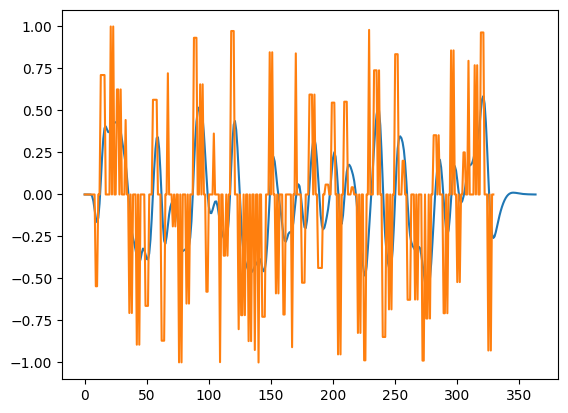

In [11]:
train_X, test_X, val_X, train_y, test_y, val_y,N = get_training_and_testing_sets(5,4)

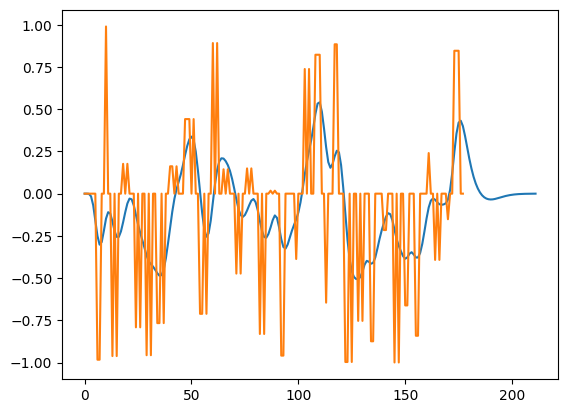

In [15]:
train_X, test_X, val_X, train_y, test_y, val_y,N = get_training_and_testing_sets(5,6)

# Reshape input to have always 10 timestamps.
 To avoid overlaps, do that for val, test, and train individually. By doing that, possible sets get lost, however, it provides a temporal solution. 

In [17]:
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)


In [21]:
# %% Getting all runs from one participant in train, val, and test sets. 

def get_all_runs_from_participant(participant_id): 
    train_X, val_X, test_X, train_y, val_y, test_y, N = get_training_and_testing_sets(participant_id,1)

    sequence_length = 10
    train_X = create_sequences(train_X, sequence_length=sequence_length)
    test_X = create_sequences(test_X, sequence_length=sequence_length)
    val_X = create_sequences(val_X, sequence_length=sequence_length)

    train_y = train_y[:-sequence_length+1]
    test_y = test_y[:-sequence_length+1]
    val_y = val_y[:-sequence_length+1]

    for run_id in [2,4,5,6]:
        #excluded run3, since run3 has for training and testing values = 0....
        subset_train_X, subset_val_X, subset_test_X, subset_train_y, subset_val_y, subset_test_y, N = get_training_and_testing_sets(participant_id,run_id)
        

        # build from "rows" for each timestamp a higher dimensional array with each 
        # a "2D" array of the size 10 (number timesteps) and 101 (number voxel)
        subset_train_X = create_sequences(subset_train_X, sequence_length=sequence_length)
        subset_val_X = create_sequences(subset_val_X, sequence_length=sequence_length)
        subset_test_X = create_sequences(subset_test_X, sequence_length=sequence_length)
        subset_train_y = subset_train_y[:-sequence_length+1]
        subset_val_y = subset_val_y[:-sequence_length+1]
        subset_test_y = subset_test_y[:-sequence_length+1]
        

        train_X = np.concatenate((train_X, subset_train_X), axis=0)
        val_X = np.concatenate((val_X, subset_val_X), axis=0)
        test_X = np.concatenate((test_X, subset_test_X), axis=0)
        train_y = np.concatenate((train_y, subset_train_y), axis=0)
        val_y = np.concatenate((val_y, subset_val_y), axis=0)
        test_y = np.concatenate((test_y, subset_test_y), axis=0)
        N = N

    return train_X, val_X, test_X, train_y, val_y, test_y, N

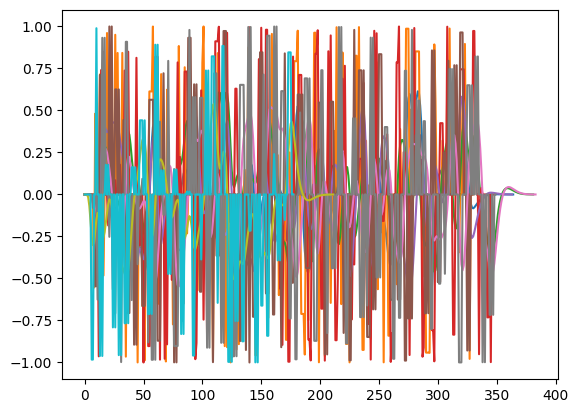

In [22]:
train_X, val_X, test_X, train_y, val_y, test_y, N = get_all_runs_from_participant(5)

In [23]:
train_X.shape

(1158, 10, 1, 101)

# Random Forest, 100 voxels.



In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [32]:
input_shape = (1,10,1,101)
model = models.Sequential([ # add more complexity, add dropout, etc! 
    layers.Conv2D(1, (3,1), activation='linear', input_shape=input_shape[1:],padding="same", kernel_initializer='he_normal'), #relu
    # layers.MaxPooling2D(pool_size=(1,3),strides=(1,2)),
    layers.Flatten(),
    layers.Dense(4, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.1), kernel_initializer='he_normal'), #relu
    layers.Dense(1, activation='linear', kernel_initializer='he_normal'), #
    layers.Normalization()
])


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.01), 
    loss='mean_squared_error', 
    metrics=["mae", 'accuracy']
)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 1, 1)          304       
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
Total params: 356
Trainable params: 353
Non-trainable params: 3
__________________________________________________________

### Visualizing the prediction of the network before training

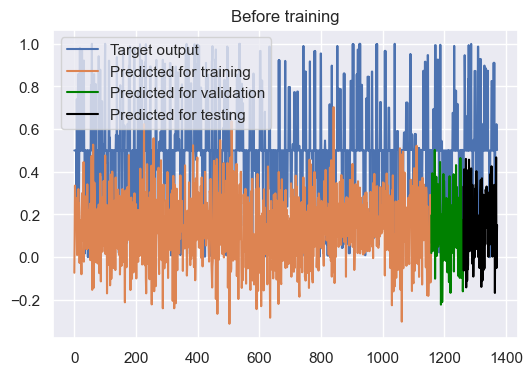

In [33]:
# Let's visualize how LTC initialy performs before the training
train_size = len(train_X)
sns.set()
prediction_train = model(train_X).numpy()
prediction_val = model(val_X).numpy()
prediction_test = model(test_X).numpy()

size_train = len(prediction_train)
size_val = len(prediction_val)
size_test = len(prediction_test)

prediction = np.concatenate((prediction_train, prediction_val, prediction_test))
data_y = np.concatenate((train_y, val_y, test_y), axis = 0).reshape(-1)


plt.figure(figsize=(6, 4))
plt.plot(data_y, label="Target output")

# pred_train_vox
c = np.empty_like(data_y) 
c[:] = np.nan
c[:size_train] = prediction_train.reshape(-1) 
plt.plot(c, label="Predicted for training")

# pred_val_vox
d = np.empty_like(data_y) 
d[:] = np.nan
d[size_train:size_train+size_val] = prediction_val.reshape(-1) 
plt.plot(d, 'green', label="Predicted for validation")

# pred_test_vox
d = np.empty_like(data_y) 
d[:] = np.nan
d[-size_test:] = prediction_test.reshape(-1) 
plt.plot(d, 'black', label="Predicted for testing")



plt.ylim()
plt.title("Before training")
plt.legend(loc="upper left")
plt.show()

In [34]:
mse = mean_squared_error(train_y.flatten(), prediction_train.flatten()) 
r2 = r2_score(train_y.flatten(), prediction_train.flatten()) 
mape = mean_absolute_percentage_error(train_y.flatten(), prediction_train.flatten()) 

print("Short Trial: MSE: " + str(mse) + "\nR2: " + str(r2) + "\nMAPE: " + str(mape))

Short Trial: MSE: 0.20212905
R2: -2.7349533345778494
MAPE: 1258226300000.0


### Setting up Weights and Biases


In [35]:
import wandb    # not used yet! 
import pprint
from wandb.keras import WandbMetricsLogger 

### Training the model

In [36]:
# Train the model for 400 epochs (= training steps)
# config = wandb.config
config ={
        "learning_rate": 0.01,
        "epochs": 400,
        "batch_size": 32    
        }

hist_full = model.fit(x=train_X, y=train_y, validation_data = (val_X, val_y), batch_size=config["batch_size"], epochs=config["epochs"],verbose=1)   # add callbacks 

Epoch 1/400
37/37 [==============================] - 1s 10ms/step - loss: 0.6828 - mae: 0.2560 - accuracy: 0.0035 - val_loss: 0.3885 - val_mae: 0.1621 - val_accuracy: 0.0096
Epoch 2/400
37/37 [==============================] - 0s 4ms/step - loss: 0.2797 - mae: 0.1728 - accuracy: 0.0043 - val_loss: 0.1756 - val_mae: 0.1471 - val_accuracy: 0.0096
Epoch 3/400
37/37 [==============================] - 0s 4ms/step - loss: 0.1403 - mae: 0.1668 - accuracy: 0.0043 - val_loss: 0.0958 - val_mae: 0.1468 - val_accuracy: 0.0096
Epoch 4/400
37/37 [==============================] - 0s 4ms/step - loss: 0.0840 - mae: 0.1595 - accuracy: 0.0060 - val_loss: 0.0653 - val_mae: 0.1417 - val_accuracy: 0.0096
Epoch 5/400
37/37 [==============================] - 0s 5ms/step - loss: 0.0638 - mae: 0.1540 - accuracy: 0.0043 - val_loss: 0.0572 - val_mae: 0.1446 - val_accuracy: 0.0096
Epoch 6/400
37/37 [==============================] - 0s 5ms/step - loss: 0.0566 - mae: 0.1478 - accuracy: 0.0035 - val_loss: 0.0524 - 

In [64]:
# Get weights of the first convolutional layer
weights = model.layers[0].get_weights()[0]

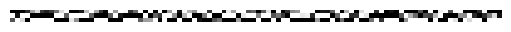

In [99]:
# Visualize weights
num_filters = weights.shape[3]
num_cols = 101
num_rows = 3

plt.figure()
for i in range(100): # num_filters
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(weights[:, :, i, 0], cmap='gray') 
    plt.axis('off')

In [105]:
# Visualize weights, dense layer
weights_dense = model.layers[2].get_weights()[0]
weights_dense

array([[ 0.00720326, -0.0049051 ,  0.01421541,  0.01018104],
       [ 0.00319792,  0.04010484,  0.00706454,  0.0101907 ],
       [-0.00013583,  0.09492306,  0.00565362,  0.0143702 ],
       [ 0.004805  ,  0.04725289,  0.01356074,  0.01349889],
       [ 0.00584128,  0.04302476,  0.00970396,  0.00498534],
       [ 0.0109637 , -0.03104689,  0.0160032 , -0.00207698],
       [ 0.00968898, -0.01229747,  0.01105134, -0.00306633],
       [ 0.01269028, -0.0242375 ,  0.01412456, -0.01036341],
       [ 0.00784566, -0.00934607,  0.00646855, -0.01213652],
       [ 0.0066629 ,  0.0136697 ,  0.00749705, -0.0086851 ]],
      dtype=float32)

(-0.5, 9.5, 3.5, -0.5)

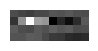

In [133]:
weights_2d = weights_dense.transpose()

plt.subplot(10, 4, 1)
plt.imshow(weights_2d, cmap='gray') 
plt.axis('off')

### Plotting the training loss

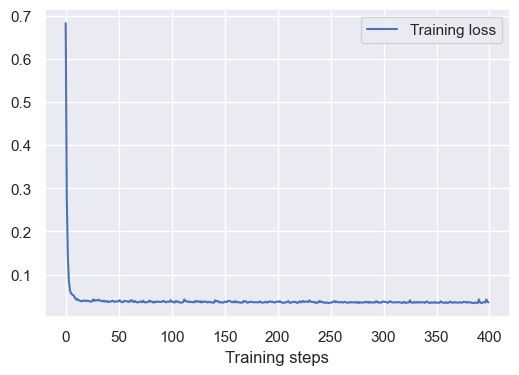

In [37]:
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist_full.history["loss"], label="Training loss")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.show()

### Plotting the prediction of the trained model


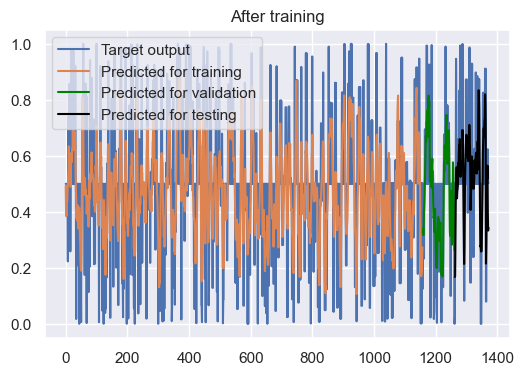

In [38]:
# Let's visualize how LTC initialy performs before the training
train_size = len(train_X)
sns.set()
prediction_train = model(train_X).numpy()
prediction_val = model(val_X).numpy()
prediction_test = model(test_X).numpy()

size_train = len(prediction_train)
size_val = len(prediction_val)
size_test = len(prediction_test)

prediction = np.concatenate((prediction_train, prediction_val, prediction_test))
data_y = np.concatenate((train_y, val_y, test_y), axis = 0).reshape(-1)

plt.figure(figsize=(6, 4))
plt.plot(data_y, label="Target output")

# pred_train_vox
c = np.empty_like(data_y) 
c[:] = np.nan
c[:size_train] = prediction_train.reshape(-1) 
plt.plot(c, label="Predicted for training")

# pred_val_vox
d = np.empty_like(data_y) 
d[:] = np.nan
d[size_train:size_train+size_val] = prediction_val.reshape(-1) 
plt.plot(d, 'green', label="Predicted for validation")

# pred_test_vox
d = np.empty_like(data_y) 
d[:] = np.nan
d[-size_test:] = prediction_test.reshape(-1) 
plt.plot(d, 'black', label="Predicted for testing")


plt.ylim() 
plt.title("After training")
plt.legend(loc="upper left")
plt.show()

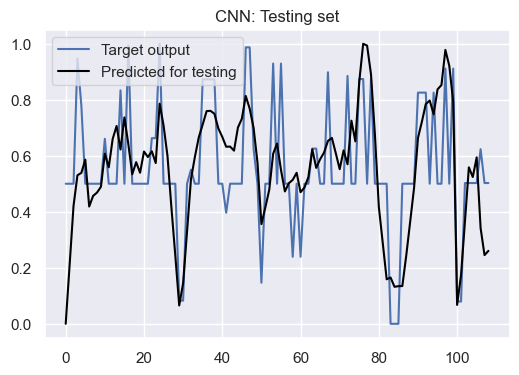

In [39]:
# Let's visualize how LTC initialy performs before the training
sns.set()

def normalize(arr, t_min=0, t_max=1):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr


# data_y = data_y.reshape(-1)
# data_y = [item for data_list in nested_data_y for sublist in data_list for subsublist in sublist for subsubsublist in subsublist for item in subsubsublist]
plt.figure(figsize=(6, 4))
plt.plot(normalize(data_y[1-size_test:]), label="Target output")

plt.plot(normalize(prediction_test.flatten()[1:]), 'black', label="Predicted for testing")



plt.ylim() #(0, 1))
plt.title("CNN: Testing set")
plt.legend(loc="upper left")
plt.show()

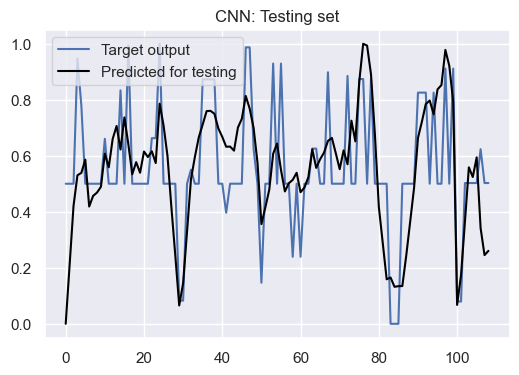

In [40]:
# Let's visualize how LTC initialy performs before the training
sns.set()

def normalize(arr, t_min=0, t_max=1):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr


# data_y = data_y.reshape(-1)
# data_y = [item for data_list in nested_data_y for sublist in data_list for subsublist in sublist for subsubsublist in subsublist for item in subsubsublist]
plt.figure(figsize=(6, 4))
plt.plot(normalize(data_y[1-size_test:]), label="Target output")

plt.plot(normalize(prediction_test.flatten()[1:]), 'black', label="Predicted for testing")



plt.ylim() #(0, 1))
plt.title("CNN: Testing set")
plt.legend(loc="upper left")
plt.show()

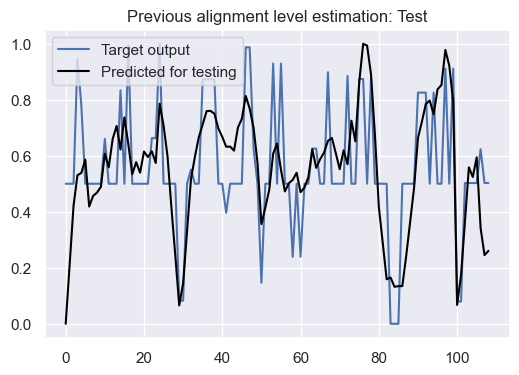

In [41]:
# Let's visualize how LTC initialy performs before the training
sns.set()

def normalize(arr, t_min=0, t_max=1):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr


# data_y = data_y.reshape(-1)
# data_y = [item for data_list in nested_data_y for sublist in data_list for subsublist in sublist for subsubsublist in subsublist for item in subsubsublist]
plt.figure(figsize=(6, 4))
plt.plot(normalize(data_y[1-size_test:]), label="Target output")

plt.plot(normalize(prediction_test.flatten()[1:]), 'black', label="Predicted for testing")



plt.ylim() #(0, 1))
plt.title("Previous alignment level estimation: Test")
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Evaluate: For train, val, test

true = test_y.flatten()
pred = normalize(prediction_test.flatten())

mse = mean_squared_error(test_y.flatten(), prediction_test.flatten()) 
r2 = r2_score(test_y.flatten(), prediction_test.flatten()) 
mape = mean_absolute_percentage_error(test_y.flatten(), prediction_test.flatten()) 
mae = mean_absolute_error(true, pred)

print(f"Test: \nMSE: {mse}\nR2: {r2}\nMAPE: {mape}\nMAE: {mae}\n\n")


# BASELINE


In [45]:
baseline = np.concatenate((train_y, test_y, val_y)) 
baseline.shape

(1372, 1, 1)

In [46]:
baseline_val = np.full(val_y.shape, np.mean(baseline))
baseline_test = np.full(test_y.shape, np.mean(baseline))
baseline_train = np.full(train_y.shape, np.mean(baseline))


# Again evaluate on that. Use: pred = baseline_train.flatten() >> should be horizontal line at 0.5 

# Novel Baseline (predicts always the last alignment level)

In [57]:
new_test_y = np.concatenate([[test_y[0]], test_y], axis=0)[:-1]

# Again evaluate on that. Use: pred = new_test_y.flatten() >> should be shifted test_y. 

In [ ]:
# Determine number of correct alignments; get percentage
alignment_count = np.sum(true == pred)
alignment_percentage = (alignment_count / len(true)) * 100

print(f"Alignment Count: {alignment_count}")
print(f"Alignment Percentage: {alignment_percentage:.2f}%")
